In [1]:
from tensorflow import keras
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import sklearn.metrics
import h5py
import pandas as pd
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


2022-11-27 03:49:29.205751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 03:49:29.275417: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TARGET_BYTE = 0 #何バイト目を攻撃するか決める

In [3]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [4]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [5]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [6]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [7]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [8]:
train_trace = train_trace[0:45000, 30824:31524]
test_trace = test_trace[45000:50000, 30824:31524]
attack_trace = attack_trace[50000:60000, 30824:31524]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [9]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [10]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [11]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [12]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [13]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [14]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

2022-11-27 03:49:31.170611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 03:49:31.171891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 03:49:31.171963: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 03:49:31.172339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [15]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [16]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [17]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

2022-11-27 03:49:32.606708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-27 03:49:33.505466: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-27 03:49:33.580220: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4e374f8010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-27 03:49:33.580237: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2022-11-27 03:49:33.582432: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-27 03:49:33.637744: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:3.1735, SR:0.7869 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:2.4455, SR:0.87515 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:2.0695, SR:0.9126333333333333 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:1.857175, SR:0.931725 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:1.6901, SR:0.94522 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:1.57665, SR:0.95425 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:1.494757142857143, SR:0.9607142857142857 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:1.433225, SR:0.965575 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:1.3852, SR:0.9693777777777778 last trace rank:1
313/3

Text(0.5, 1.0, 'target_0byte')

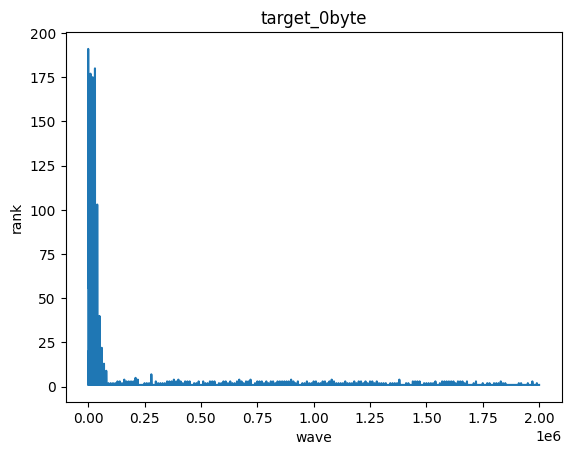

In [18]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

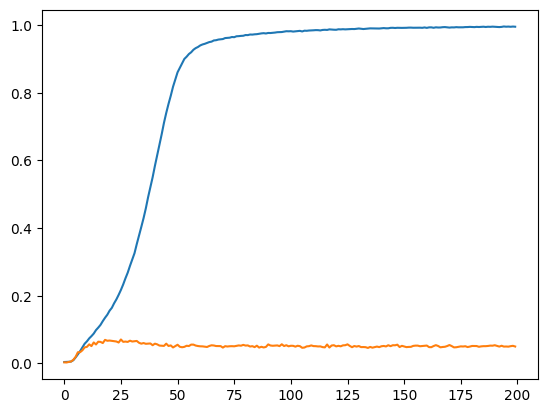

In [19]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [20]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [21]:
attack_plain=attack_metadata['plaintext']

In [22]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [23]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [24]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_0byte')

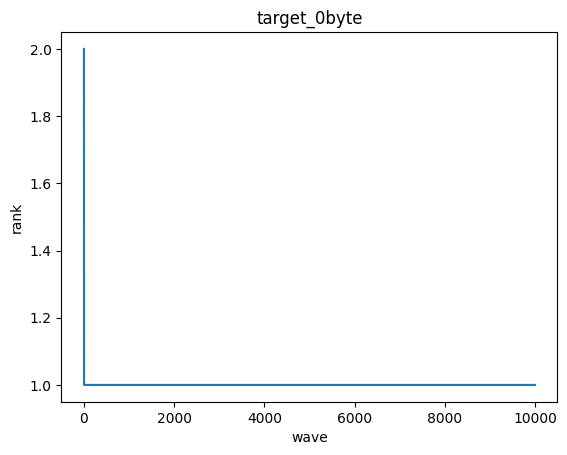

In [25]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [26]:
TARGET_BYTE = 1 #何バイト目を攻撃するか決める

In [27]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [28]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [29]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [30]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [31]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [32]:
train_trace = train_trace[0:45000, 24577:25277]
test_trace = test_trace[45000:50000, 24577:25277]
attack_trace = attack_trace[50000:60000, 24577:25277]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [33]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [34]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [35]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [36]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [37]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [38]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [39]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [40]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [41]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:4.159, SR:0.8308 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:3.14865, SR:0.87955 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:2.6322666666666668, SR:0.9083333333333333 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:2.305025, SR:0.929275 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:2.05016, SR:0.94318 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:1.87695, SR:0.95255 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:1.7518857142857143, SR:0.9592714285714286 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:1.6590875, SR:0.964275 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:1.5863, SR:0.9682111111111111 last tra

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 178 - GE:1.1998752808988764, SR:0.9972039325842696 last trace rank:166
313/313 [==============================] - 2s 5ms/step
Epoch 179 - GE:1.1987720670391062, SR:0.9972184357541899 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 180 - GE:1.1976777777777778, SR:0.9972333333333333 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 181 - GE:1.1966077348066297, SR:0.9972475138121547 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 182 - GE:1.1955456043956043, SR:0.9972615384615384 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 183 - GE:1.1944868852459016, SR:0.997275956284153 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 184 - GE:1.1934478260869565, SR:0.9972896739130435 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 185 - GE:1.1924172972972973, SR:0.9973032432432433 last trace rank:1
313/313 [=====

Text(0.5, 1.0, 'target_1byte')

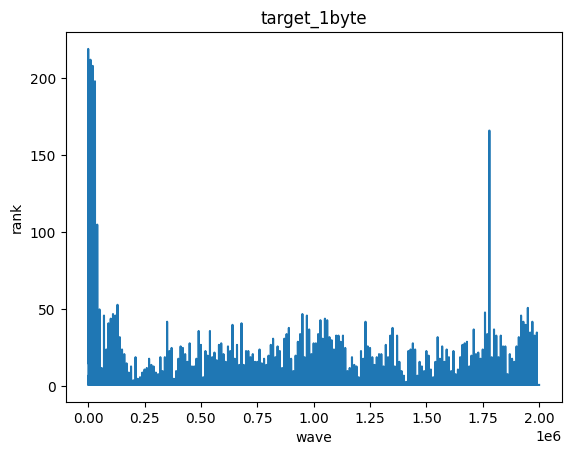

In [42]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

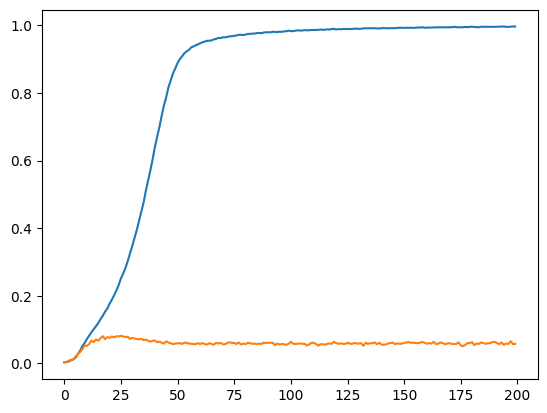

In [43]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [44]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [45]:
attack_plain=attack_metadata['plaintext']

In [46]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [47]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [48]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_1byte')

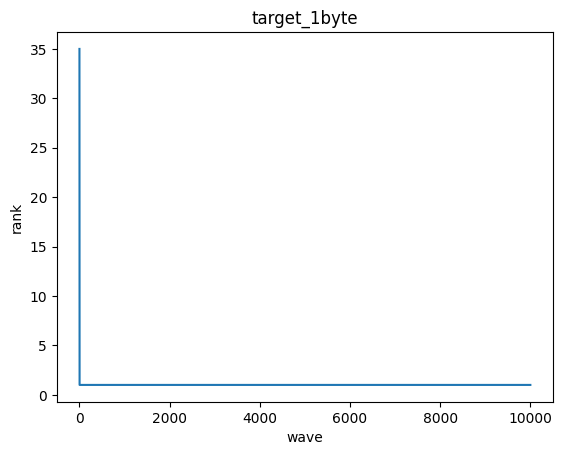

In [49]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [50]:
TARGET_BYTE = 2 #何バイト目を攻撃するか決める

In [51]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [52]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [53]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [54]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [55]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [56]:
train_trace = train_trace[0:45000, 45400:46100]
test_trace = test_trace[45000:50000, 45400:46100]
attack_trace = attack_trace[50000:60000, 45400:46100]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [57]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [58]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [59]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [60]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [61]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [62]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [63]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [64]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [65]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:247.941, SR:0.0 last trace rank:228
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:247.119, SR:0.0 last trace rank:233
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:246.58323333333334, SR:0.0 last trace rank:235
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:246.03105, SR:0.0 last trace rank:236
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:244.7112, SR:0.0 last trace rank:230
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:242.95365, SR:0.0 last trace rank:226
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:241.33201428571428, SR:0.0 last trace rank:224
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:238.8008, SR:0.0 last trace rank:213
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:236.3072, SR:0.0 last trace rank:211
313/313 [==========================

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 109 - GE:45.14377155963303, SR:0.6617660550458716 last trace rank:161
313/313 [==============================] - 2s 5ms/step
Epoch 110 - GE:44.751242727272725, SR:0.6643472727272727 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 111 - GE:44.36894234234234, SR:0.6662747747747748 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 112 - GE:43.989525892857145, SR:0.6678964285714286 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 113 - GE:43.62894336283186, SR:0.6689407079646018 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 114 - GE:43.271769298245616, SR:0.6699052631578948 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 115 - GE:42.92593217391304, SR:0.6708113043478261 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 116 - GE:42.58156034482759, SR:0.6718 last trace rank:1
313/313 [=====================

Text(0.5, 1.0, 'target_2byte')

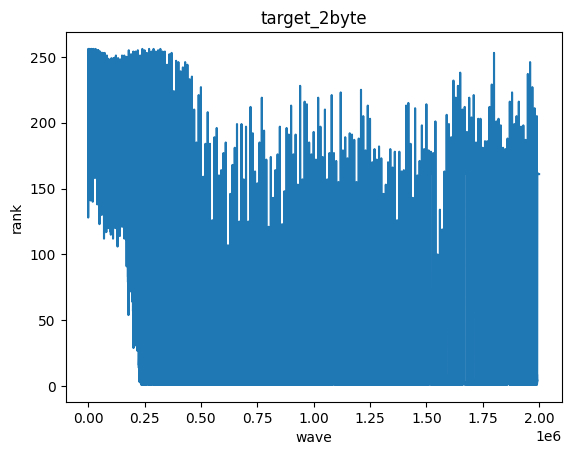

In [66]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

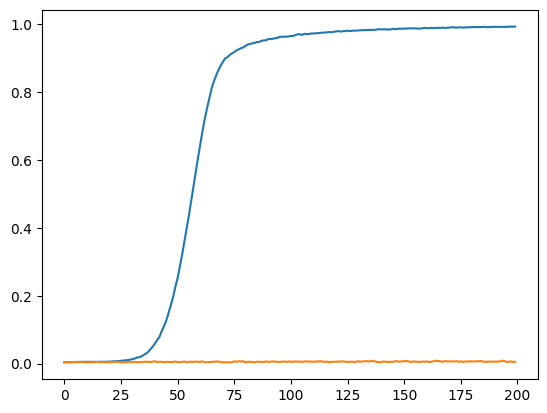

In [67]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [68]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [69]:
attack_plain=attack_metadata['plaintext']

In [70]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [71]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [72]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_2byte')

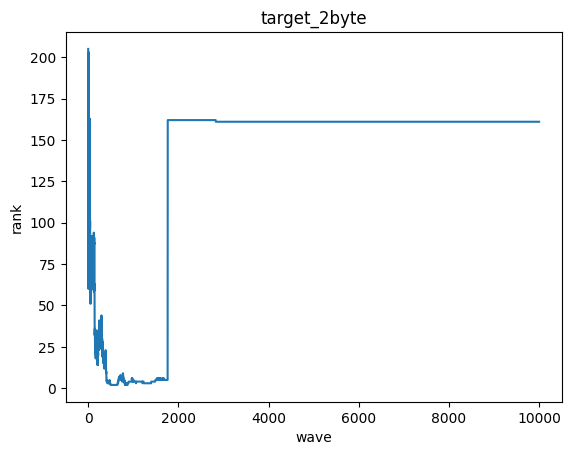

In [73]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [74]:
TARGET_BYTE = 3 #何バイト目を攻撃するか決める

In [75]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [76]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [77]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [78]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [79]:
train_trace = train_trace[0:45000, 32906:33606]
test_trace = test_trace[45000:50000, 32906:33606]
attack_trace = attack_trace[50000:60000, 32906:33606]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [80]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [81]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [82]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [83]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [84]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [85]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [86]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [87]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [88]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:76.9391, SR:0.0 last trace rank:105
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:79.0001, SR:0.0 last trace rank:101
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:82.36483333333334, SR:0.0 last trace rank:103
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:85.54475, SR:0.0 last trace rank:98
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:87.93754, SR:0.0 last trace rank:96
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:90.53043333333333, SR:0.0 last trace rank:101
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:91.42865714285715, SR:0.0 last trace rank:82
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:92.90975, SR:0.0 last trace rank:112
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:93.28942222222223, SR:0.0 last trace rank:82
313/313 [================

Text(0.5, 1.0, 'target_3byte')

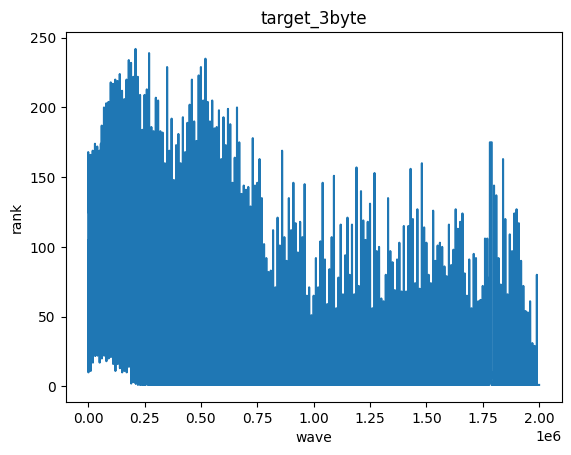

In [89]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

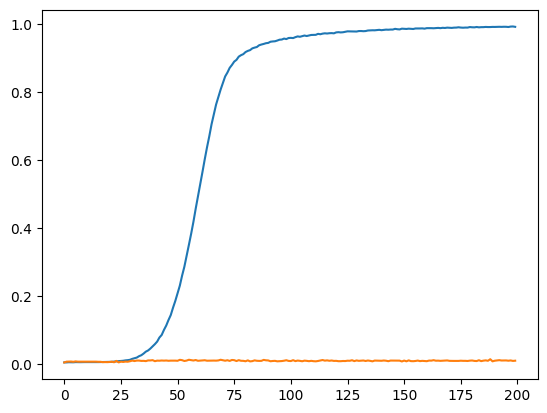

In [90]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [91]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [92]:
attack_plain=attack_metadata['plaintext']

In [93]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [94]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [95]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_3byte')

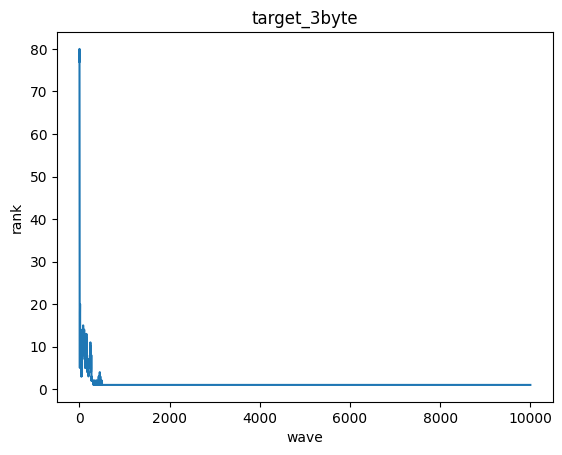

In [96]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [97]:
TARGET_BYTE = 4 #何バイト目を攻撃するか決める

In [98]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [99]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [100]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [101]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [102]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [103]:
train_trace = train_trace[0:45000, 47482:48182]
test_trace = test_trace[45000:50000, 47482:48182]
attack_trace = attack_trace[50000:60000, 47482:48182]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [104]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [105]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [106]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [107]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [108]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [109]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [110]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [111]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [112]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:196.5941, SR:0.0 last trace rank:177
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:204.1107, SR:0.0 last trace rank:203
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:206.4225, SR:0.0 last trace rank:200
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:208.1397, SR:0.0 last trace rank:200
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:208.3876, SR:8e-05 last trace rank:205
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:208.01905, SR:0.00075 last trace rank:204
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:207.0039857142857, SR:0.0018142857142857142 last trace rank:199
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:205.193925, SR:0.002175 last trace rank:181
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:204.05086666666668, SR:0.0022555555555555554 last t

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 103 - GE:34.84816213592233, SR:0.7428495145631068 last trace rank:47
313/313 [==============================] - 2s 5ms/step
Epoch 104 - GE:34.52358173076923, SR:0.7451711538461538 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 105 - GE:34.204970476190475, SR:0.7475457142857143 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 106 - GE:33.8923858490566, SR:0.7498066037735849 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 107 - GE:33.58591775700935, SR:0.7520570093457944 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 108 - GE:33.285575, SR:0.7542157407407407 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 109 - GE:32.990946788990826, SR:0.7563146788990825 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 110 - GE:32.70388454545454, SR:0.7582436363636363 last trace rank:1
313/313 [====================

Text(0.5, 1.0, 'target_4byte')

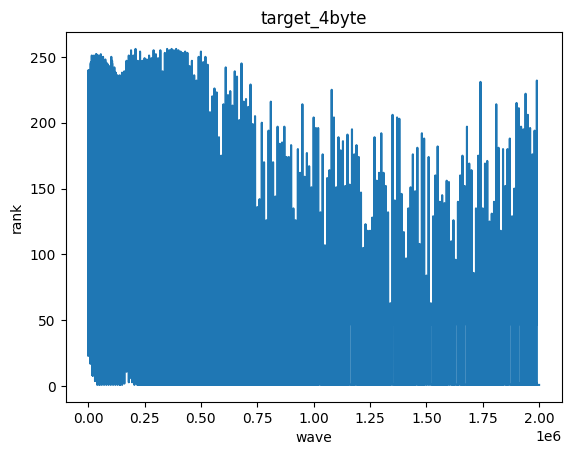

In [113]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

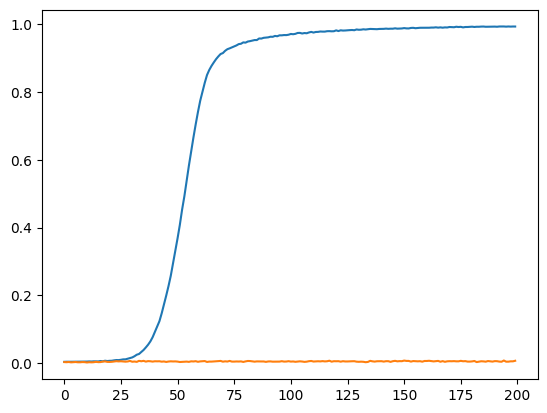

In [114]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [115]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [116]:
attack_plain=attack_metadata['plaintext']

In [117]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [118]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [119]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_4byte')

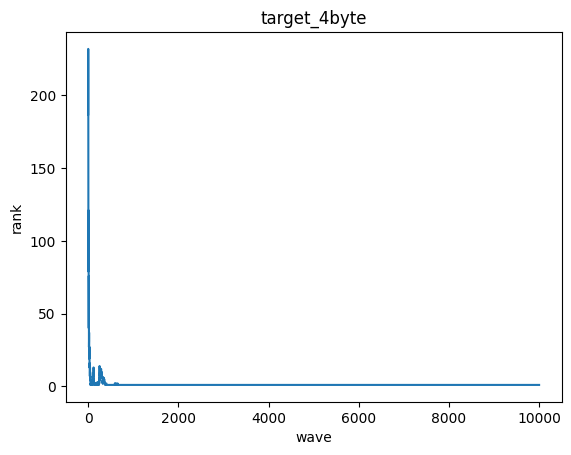

In [120]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [121]:
TARGET_BYTE = 5 #何バイト目を攻撃するか決める

In [122]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [123]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [124]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [125]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [126]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [127]:
train_trace = train_trace[0:45000, 41235:41935]
test_trace = test_trace[45000:50000, 41235:41935]
attack_trace = attack_trace[50000:60000, 41235:41935]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [128]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [129]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [130]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [131]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [132]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [133]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [134]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [135]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [136]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:112.4163, SR:0.0 last trace rank:102
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:114.02335, SR:0.0 last trace rank:70
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:115.44993333333333, SR:0.0 last trace rank:53
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:117.821575, SR:0.0 last trace rank:48
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:120.91544, SR:0.0 last trace rank:58
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:122.01991666666666, SR:0.0 last trace rank:50
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:122.74667142857143, SR:0.0 last trace rank:50
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:124.197, SR:0.0 last trace rank:55
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:125.93083333333334, SR:0.0 last trace rank:60
313/313 [===========

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 186 - GE:11.918956451612903, SR:0.8912844086021505 last trace rank:127
313/313 [==============================] - 2s 5ms/step
Epoch 187 - GE:11.860911764705882, SR:0.8918422459893048 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 188 - GE:12.426243617021276, SR:0.8874547872340426 last trace rank:127
313/313 [==============================] - 2s 5ms/step
Epoch 189 - GE:12.366048148148149, SR:0.8880296296296296 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 190 - GE:12.306547368421052, SR:0.8885742105263158 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 191 - GE:12.247710471204188, SR:0.8891109947643979 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 192 - GE:12.189435416666667, SR:0.8896567708333334 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 193 - GE:12.131782901554404, SR:0.8902 last trace rank:1
313/313 [==============

Text(0.5, 1.0, 'target_5byte')

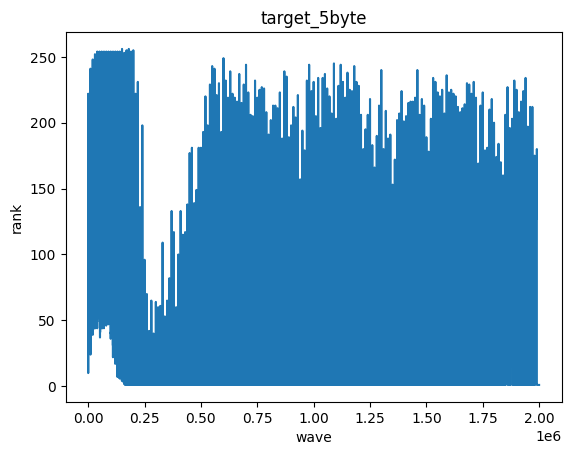

In [137]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

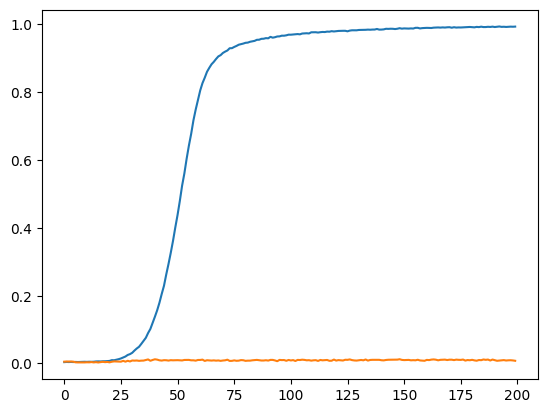

In [138]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [139]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [140]:
attack_plain=attack_metadata['plaintext']

In [141]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [142]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [143]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_5byte')

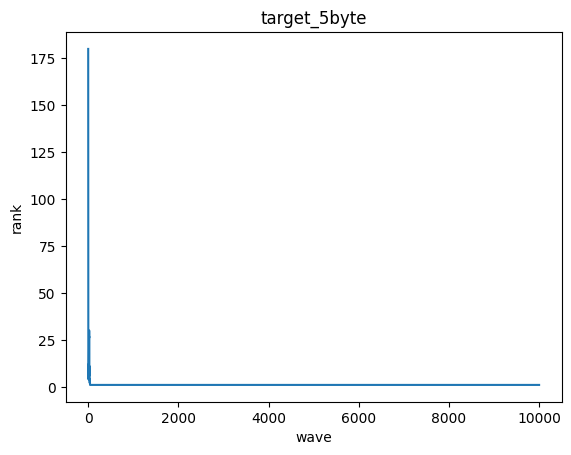

In [144]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [145]:
TARGET_BYTE = 6 #何バイト目を攻撃するか決める

In [146]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [147]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [148]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [149]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [150]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [151]:
train_trace = train_trace[0:45000, 37071:37771]
test_trace = test_trace[45000:50000, 37071:37771]
attack_trace = attack_trace[50000:60000, 37071:37771]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [152]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [153]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [154]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [155]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [156]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [157]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [158]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [159]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [160]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:134.2086, SR:0.0 last trace rank:82
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:143.3024, SR:0.0 last trace rank:114
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:150.96243333333334, SR:0.0 last trace rank:136
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:155.29195, SR:0.0 last trace rank:140
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:159.41052, SR:0.0 last trace rank:157
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:161.82671666666667, SR:0.0 last trace rank:177
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:163.31337142857143, SR:0.0 last trace rank:183
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:164.565475, SR:0.0 last trace rank:191
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:166.07265555555554, SR:0.0 last trace rank:194
313/313 [===

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 93 - GE:53.44337741935484, SR:0.5559161290322581 last trace rank:2
313/313 [==============================] - 2s 5ms/step
Epoch 94 - GE:52.893378723404254, SR:0.5592276595744681 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 95 - GE:52.36211157894737, SR:0.5624621052631579 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 96 - GE:51.836053125, SR:0.5658729166666666 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 97 - GE:51.322492783505155, SR:0.5691051546391752 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 98 - GE:50.8152806122449, SR:0.5726204081632653 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 99 - GE:50.323307070707074, SR:0.5755292929292929 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 100 - GE:49.843514, SR:0.578165 last trace rank:1
313/313 [==============================] - 2s 5ms/s

Text(0.5, 1.0, 'target_6byte')

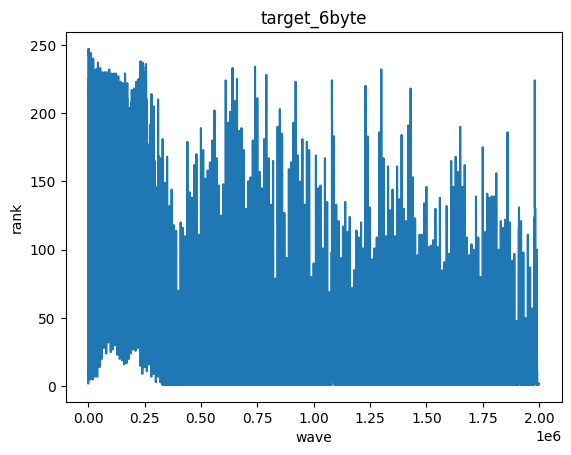

In [161]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

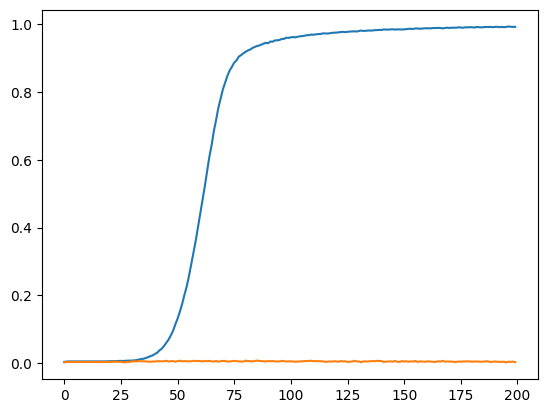

In [162]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [163]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [164]:
attack_plain=attack_metadata['plaintext']

In [165]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [166]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [167]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

/tmp/ipykernel_10/4286253314.py:8: RuntimeWarning: invalid value encountered in true_divide
  result2 = result2 /np.sum(result2)


Text(0.5, 1.0, 'target_6byte')

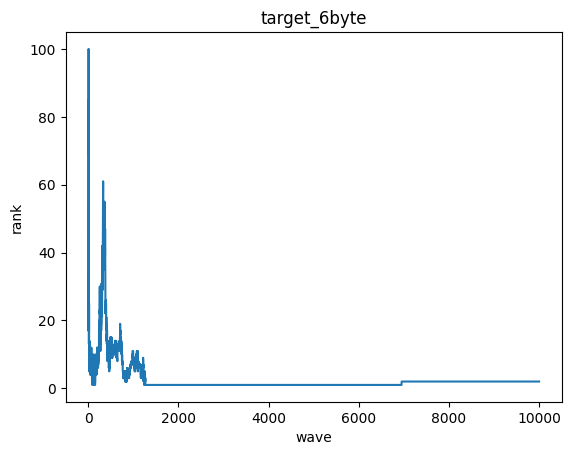

In [168]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [169]:
TARGET_BYTE = 7 #何バイト目を攻撃するか決める

In [170]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [171]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [172]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [173]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [174]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [175]:
train_trace = train_trace[0:45000, 34989:35689]
test_trace = test_trace[45000:50000, 34989:35689]
attack_trace = attack_trace[50000:60000, 34989:35689]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [176]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [177]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [178]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [179]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [180]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [181]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [182]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [183]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [184]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:24.3012, SR:0.0024 last trace rank:17
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:22.41875, SR:0.0822 last trace rank:6
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:21.3298, SR:0.14543333333333333 last trace rank:3
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:21.1617, SR:0.1816 last trace rank:3
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:21.84636, SR:0.20052 last trace rank:4
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:22.143666666666668, SR:0.21618333333333334 last trace rank:4
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:22.6987, SR:0.21907142857142858 last trace rank:5
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:22.5503, SR:0.2327375 last trace rank:2
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:22.550555555555555, SR:0.2317 last 

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 198 - GE:6.145830808080808, SR:0.7974035353535354 last trace rank:80
313/313 [==============================] - 2s 5ms/step
Epoch 199 - GE:6.138374874371859, SR:0.7979763819095478 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 200 - GE:6.1394875, SR:0.798223 last trace rank:80


Text(0.5, 1.0, 'target_7byte')

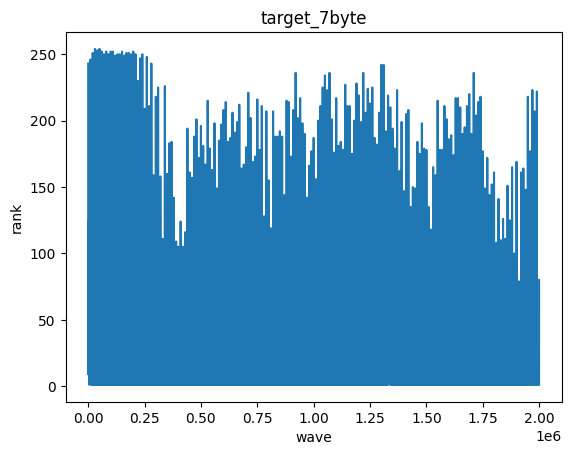

In [185]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

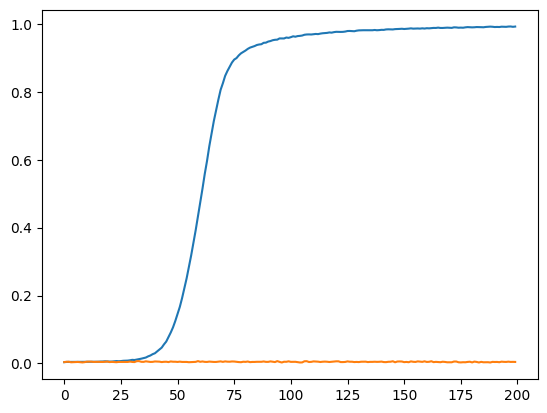

In [186]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [187]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [188]:
attack_plain=attack_metadata['plaintext']

In [189]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [190]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [191]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

/tmp/ipykernel_10/4286253314.py:8: RuntimeWarning: invalid value encountered in true_divide
  result2 = result2 /np.sum(result2)


Text(0.5, 1.0, 'target_7byte')

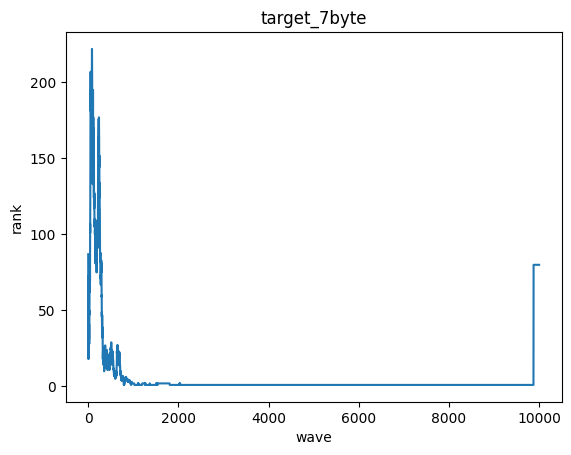

In [192]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [193]:
TARGET_BYTE = 8 #何バイト目を攻撃するか決める

In [194]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [195]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [196]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [197]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [198]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [199]:
train_trace = train_trace[0:45000, 26660:27360]
test_trace = test_trace[45000:50000, 26660:27360]
attack_trace = attack_trace[50000:60000, 26660:27360]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [200]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [201]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [202]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [203]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [204]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [205]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [206]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [207]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [208]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:185.749, SR:0.0 last trace rank:220
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:192.0639, SR:0.0 last trace rank:223
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:194.22056666666666, SR:0.0 last trace rank:223
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:194.933, SR:0.0 last trace rank:226
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:195.32712, SR:0.0 last trace rank:224
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:195.78136666666666, SR:0.0 last trace rank:228
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:196.4266142857143, SR:0.0 last trace rank:227
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:197.148925, SR:0.0 last trace rank:228
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:197.28688888888888, SR:0.0 last trace rank:224
313/313 [======

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 142 - GE:159.50154647887325, SR:0.16628380281690142 last trace rank:250
313/313 [==============================] - 2s 5ms/step
Epoch 143 - GE:159.98574615384615, SR:0.16512097902097903 last trace rank:250
313/313 [==============================] - 2s 5ms/step
Epoch 144 - GE:160.49238819444443, SR:0.16397430555555556 last trace rank:250
313/313 [==============================] - 2s 5ms/step
Epoch 145 - GE:161.0083344827586, SR:0.16284344827586206 last trace rank:250
313/313 [==============================] - 2s 5ms/step
Epoch 146 - GE:161.5250691780822, SR:0.1617280821917808 last trace rank:249
313/313 [==============================] - 2s 5ms/step
Epoch 147 - GE:162.0457142857143, SR:0.1606278911564626 last trace rank:250
313/313 [==============================] - 2s 5ms/step
Epoch 148 - GE:162.5331418918919, SR:0.15954256756756757 last trace rank:250
313/313 [==============================] - 2s 5ms/step
Epoch 149 - GE:163.053, SR:0.1584718120805369 last trace rank:250
313/313 [

Text(0.5, 1.0, 'target_8byte')

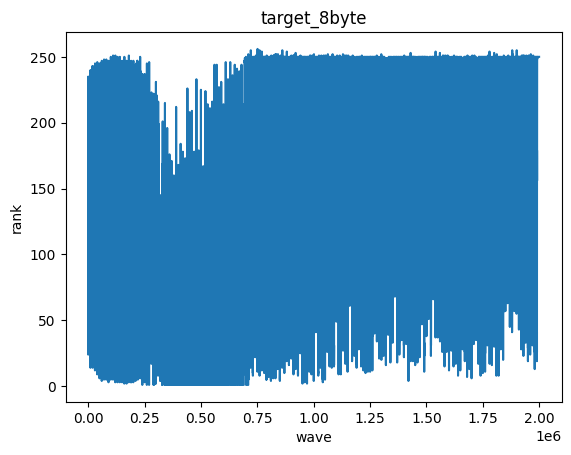

In [209]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

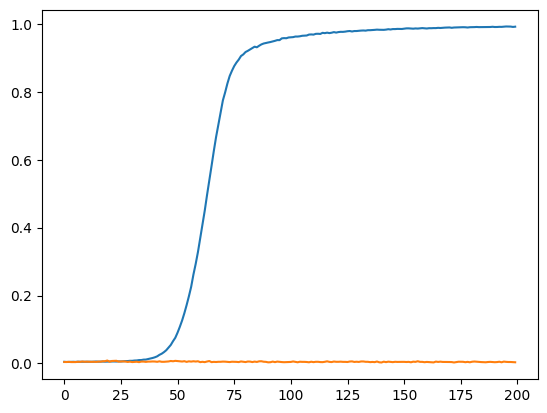

In [210]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [211]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [212]:
attack_plain=attack_metadata['plaintext']

In [213]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [214]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [215]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_8byte')

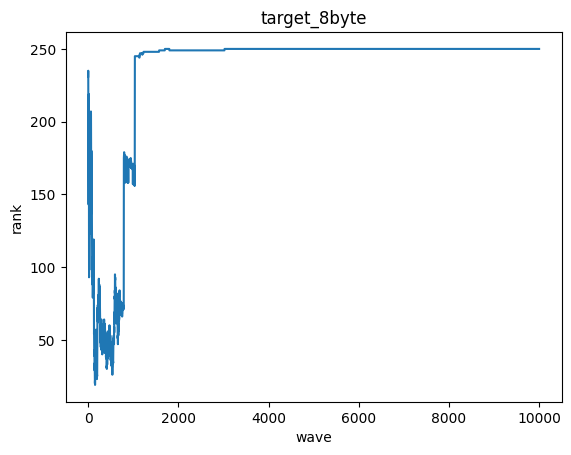

In [216]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [217]:
TARGET_BYTE = 9 #何バイト目を攻撃するか決める

In [218]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [219]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [220]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [221]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [222]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [223]:
train_trace = train_trace[0:45000, 39154:39854]
test_trace = test_trace[45000:50000, 39154:39854]
attack_trace = attack_trace[50000:60000, 39154:39854]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [224]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [225]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [226]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [227]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [228]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [229]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [230]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [231]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [232]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:103.9288, SR:0.0033 last trace rank:103
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:96.82235, SR:0.00195 last trace rank:101
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:89.7847, SR:0.0017666666666666666 last trace rank:98
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:85.1151, SR:0.001475 last trace rank:94
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:80.4061, SR:0.00118 last trace rank:81
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:79.01121666666667, SR:0.0009833333333333332 last trace rank:102
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:78.17598571428572, SR:0.0008428571428571428 last trace rank:104
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:77.61995, SR:0.0007375 last trace rank:100
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:77.2

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 174 - GE:137.2283344827586, SR:0.15995402298850575 last trace rank:212
313/313 [==============================] - 2s 5ms/step
Epoch 175 - GE:137.56451314285715, SR:0.15904 last trace rank:212
313/313 [==============================] - 2s 5ms/step
Epoch 176 - GE:137.91447329545454, SR:0.15813636363636363 last trace rank:211
313/313 [==============================] - 2s 5ms/step
Epoch 177 - GE:138.322190960452, SR:0.15724293785310733 last trace rank:211
313/313 [==============================] - 2s 5ms/step
Epoch 178 - GE:138.63242359550563, SR:0.15635955056179776 last trace rank:211
313/313 [==============================] - 2s 5ms/step
Epoch 179 - GE:138.9910905027933, SR:0.15548603351955306 last trace rank:211
313/313 [==============================] - 2s 5ms/step
Epoch 180 - GE:139.29187944444445, SR:0.15462222222222222 last trace rank:211
313/313 [==============================] - 2s 5ms/step
Epoch 181 - GE:139.61254475138122, SR:0.15376795580110497 last trace rank:211
313/313

Text(0.5, 1.0, 'target_9byte')

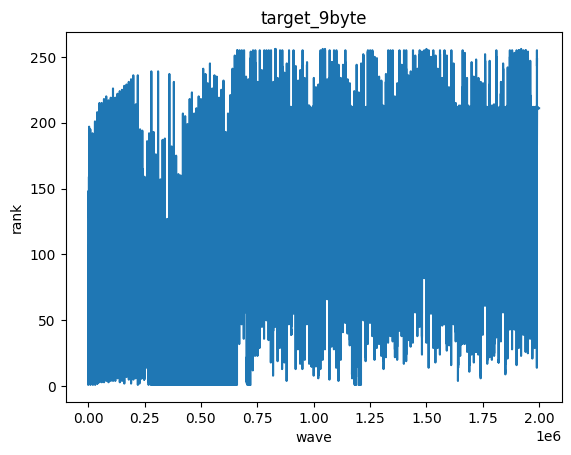

In [233]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

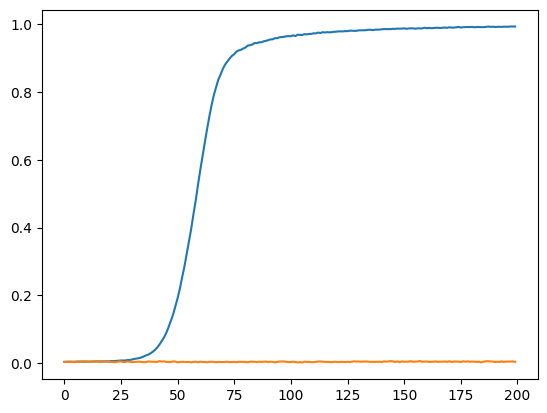

In [234]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [235]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [236]:
attack_plain=attack_metadata['plaintext']

In [237]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [238]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [239]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_9byte')

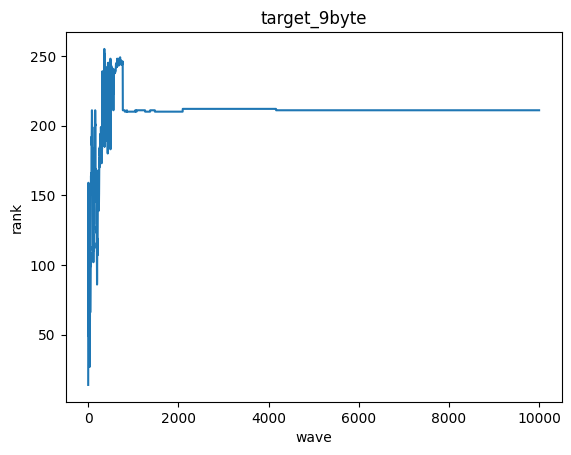

In [240]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [241]:
TARGET_BYTE = 10 #何バイト目を攻撃するか決める

In [242]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [243]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [244]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [245]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [246]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [247]:
train_trace = train_trace[0:45000, 28742:29442]
test_trace = test_trace[45000:50000, 28742:29442]
attack_trace = attack_trace[50000:60000, 28742:29442]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [248]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [249]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [250]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [251]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [252]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [253]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [254]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [255]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [256]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:200.985, SR:0.0 last trace rank:219
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:188.8851, SR:0.0 last trace rank:185
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:180.3552, SR:0.0 last trace rank:175
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:170.81875, SR:0.0 last trace rank:142
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:161.50896, SR:0.0 last trace rank:129
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:152.78633333333335, SR:0.0 last trace rank:114
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:145.73978571428572, SR:0.0 last trace rank:98
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:138.3500125, SR:0.0 last trace rank:73
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:132.75232222222223, SR:0.0 last trace rank:76
313/313 [===============

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 197 - GE:14.221217766497462, SR:0.7270984771573604 last trace rank:22
313/313 [==============================] - 2s 5ms/step
Epoch 198 - GE:14.160771717171718, SR:0.7274565656565657 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 199 - GE:14.111543216080403, SR:0.7280201005025125 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 200 - GE:14.0713555, SR:0.727714 last trace rank:1


Text(0.5, 1.0, 'target_10byte')

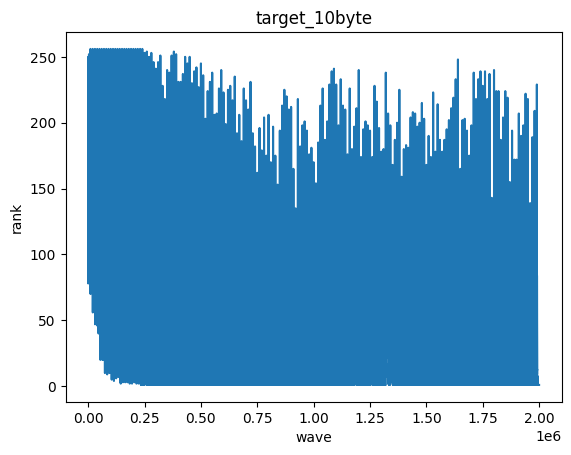

In [257]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

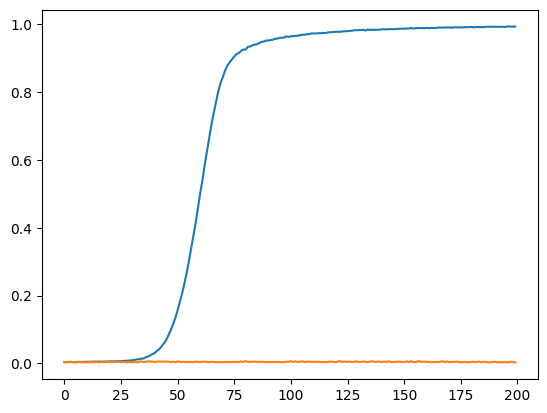

In [258]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [259]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [260]:
attack_plain=attack_metadata['plaintext']

In [261]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [262]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [263]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_10byte')

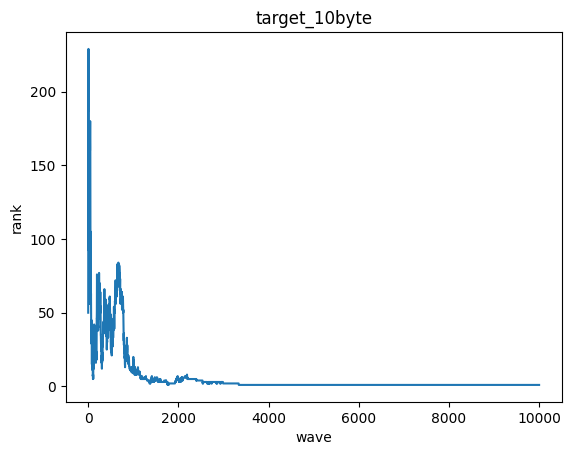

In [264]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [265]:
TARGET_BYTE = 11 #何バイト目を攻撃するか決める

In [266]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [267]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [268]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [269]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [270]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [271]:
train_trace = train_trace[0:45000, 43318:44018]
test_trace = test_trace[45000:50000, 43318:44018]
attack_trace = attack_trace[50000:60000, 43318:44018]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [272]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [273]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [274]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [275]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [276]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [277]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [278]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [279]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [280]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:123.6493, SR:0.0029 last trace rank:102
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:115.2301, SR:0.00145 last trace rank:71
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:106.6375, SR:0.0009666666666666667 last trace rank:41
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:100.2167, SR:0.000725 last trace rank:28
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:93.58954, SR:0.00058 last trace rank:25
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:89.25066666666666, SR:0.00048333333333333334 last trace rank:27
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:85.84362857142857, SR:0.0004142857142857143 last trace rank:28
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:83.4221625, SR:0.0003625 last trace rank:28
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:81

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 117 - GE:18.252773504273506, SR:0.6832692307692307 last trace rank:133
313/313 [==============================] - 2s 5ms/step
Epoch 118 - GE:18.117855084745763, SR:0.6850203389830508 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 119 - GE:17.98853949579832, SR:0.6866663865546219 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 120 - GE:17.862344166666666, SR:0.6886 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 121 - GE:17.73160991735537, SR:0.6904644628099174 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 122 - GE:17.614927049180327, SR:0.692266393442623 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 123 - GE:17.49789756097561, SR:0.6941138211382114 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 124 - GE:17.390581451612903, SR:0.6957451612903226 last trace rank:1
313/313 [====================

Text(0.5, 1.0, 'target_11byte')

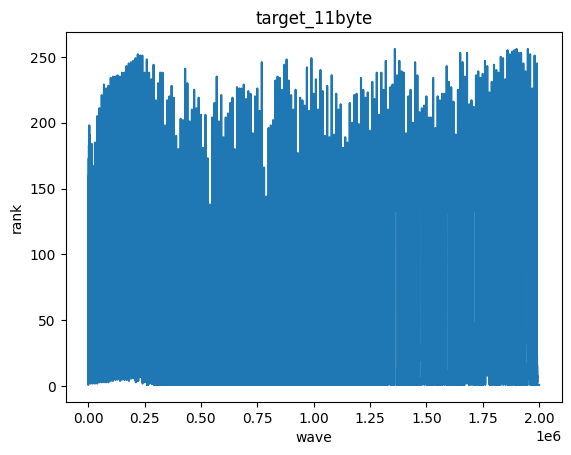

In [281]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

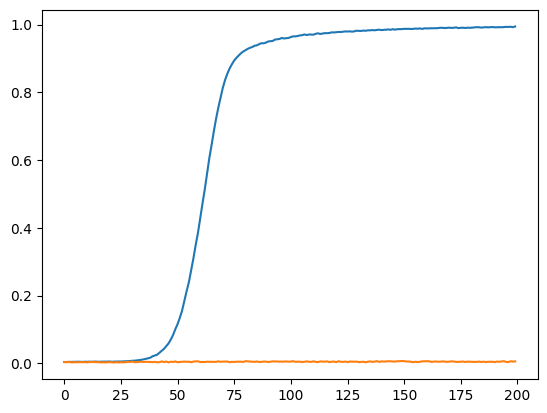

In [282]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [283]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [284]:
attack_plain=attack_metadata['plaintext']

In [285]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [286]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [287]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_11byte')

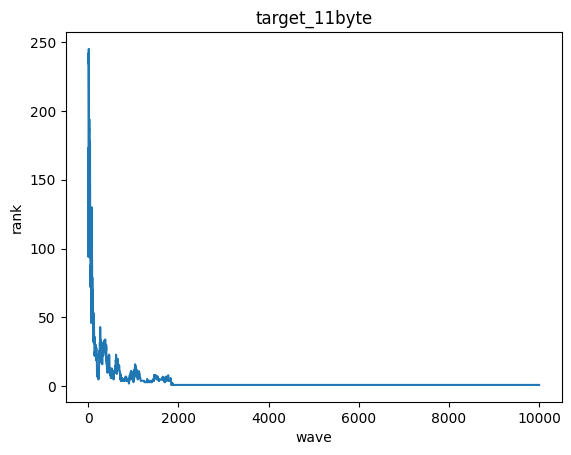

In [288]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [289]:
TARGET_BYTE = 12 #何バイト目を攻撃するか決める

In [290]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [291]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [292]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [293]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [294]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [295]:
train_trace = train_trace[0:45000, 20413:21113]
test_trace = test_trace[45000:50000, 20413:21113]
attack_trace = attack_trace[50000:60000, 20413:21113]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [296]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [297]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [298]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [299]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [300]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [301]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [302]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [303]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [304]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:166.2721, SR:0.0 last trace rank:120
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:181.7625, SR:0.0 last trace rank:178
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:192.05353333333332, SR:0.0 last trace rank:203
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:199.65545, SR:0.0 last trace rank:222
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:205.97102, SR:0.0 last trace rank:234
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:210.64596666666668, SR:0.0 last trace rank:242
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:214.3146142857143, SR:0.0 last trace rank:244
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:217.3617875, SR:0.0 last trace rank:246
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:219.67436666666666, SR:0.0 last trace rank:245
313/313 [==

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 181 - GE:46.80811049723757, SR:0.6683480662983425 last trace rank:211
313/313 [==============================] - 2s 5ms/step
Epoch 182 - GE:47.25955, SR:0.6656076923076923 last trace rank:211
313/313 [==============================] - 2s 5ms/step
Epoch 183 - GE:47.02270655737705, SR:0.6661666666666667 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 184 - GE:46.779495652173914, SR:0.6672809782608695 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 185 - GE:46.55527405405405, SR:0.6680054054054054 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 186 - GE:46.32770913978494, SR:0.6687387096774193 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 187 - GE:46.10421497326203, SR:0.669555614973262 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 188 - GE:45.88792127659575, SR:0.6700877659574468 last trace rank:1
313/313 [===================

Text(0.5, 1.0, 'target_12byte')

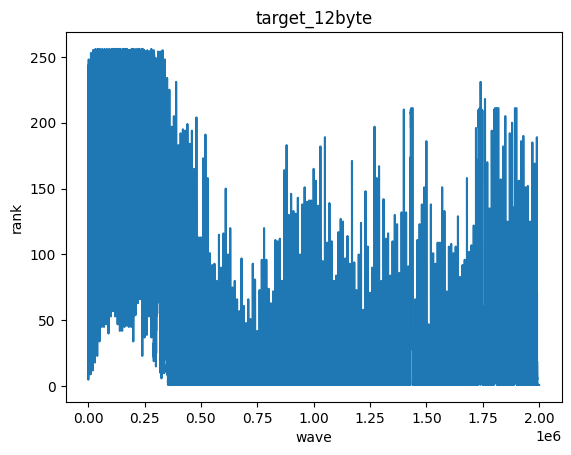

In [305]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

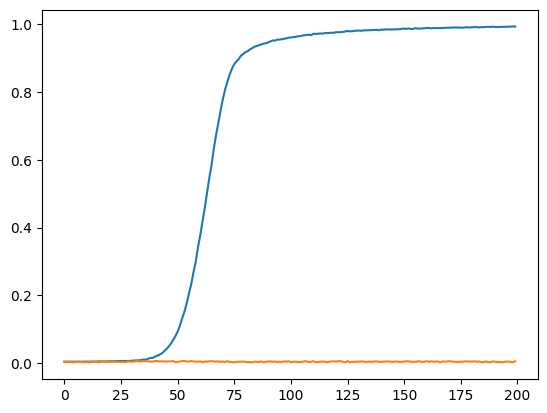

In [306]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [307]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [308]:
attack_plain=attack_metadata['plaintext']

In [309]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [310]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [311]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_12byte')

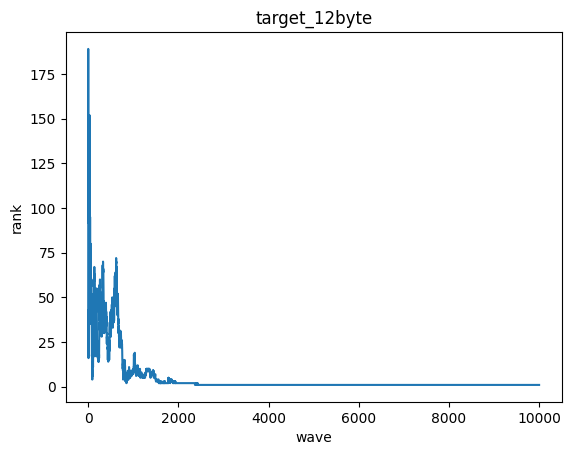

In [312]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [313]:
TARGET_BYTE = 13 #何バイト目を攻撃するか決める

In [314]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [315]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [316]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [317]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [318]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [319]:
train_trace = train_trace[0:45000, 22495:23195]
test_trace = test_trace[45000:50000, 22495:23195]
attack_trace = attack_trace[50000:60000, 22495:23195]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [320]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [321]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [322]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [323]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [324]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [325]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [326]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [327]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [328]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:25.6156, SR:0.0 last trace rank:5
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:26.94785, SR:0.0 last trace rank:4
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:30.5643, SR:0.0 last trace rank:7
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:32.57415, SR:0.0 last trace rank:6
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:35.51504, SR:0.0 last trace rank:7
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:38.5961, SR:0.0 last trace rank:5
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:41.340042857142855, SR:0.0 last trace rank:6
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:44.591325, SR:0.0 last trace rank:9
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:46.81933333333333, SR:0.0 last trace rank:8
313/313 [==============================] - 2s 5ms/step
E

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 102 - GE:21.305001960784313, SR:0.5793049019607843 last trace rank:23
313/313 [==============================] - 2s 5ms/step
Epoch 103 - GE:21.139979611650485, SR:0.5817941747572816 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 104 - GE:20.976785576923078, SR:0.5843480769230769 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 105 - GE:20.81587238095238, SR:0.5867238095238095 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 106 - GE:20.698328301886793, SR:0.5882660377358491 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 107 - GE:20.54021588785047, SR:0.5906149532710281 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 108 - GE:20.39028888888889, SR:0.5928694444444444 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 109 - GE:20.22627339449541, SR:0.5951871559633027 last trace rank:1
313/313 [=========

Text(0.5, 1.0, 'target_13byte')

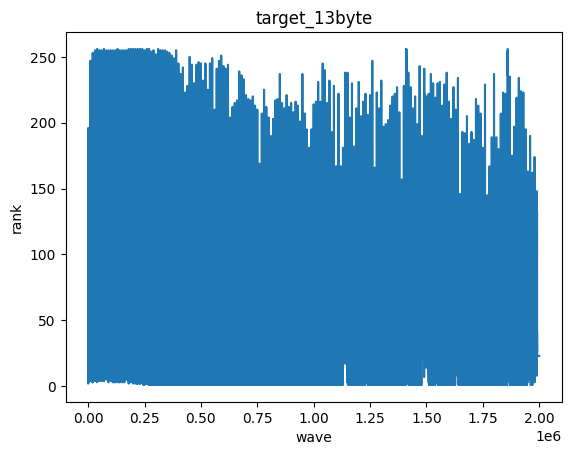

In [329]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

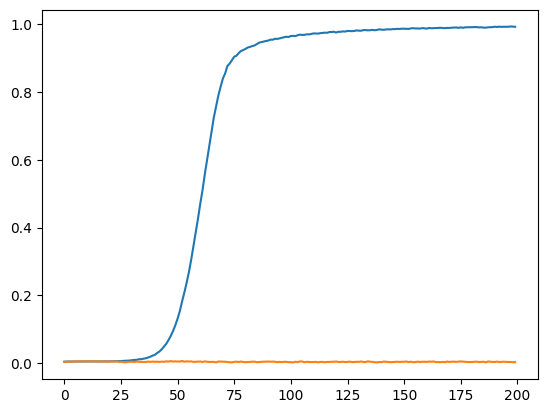

In [330]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [331]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [332]:
attack_plain=attack_metadata['plaintext']

In [333]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [334]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [335]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_13byte')

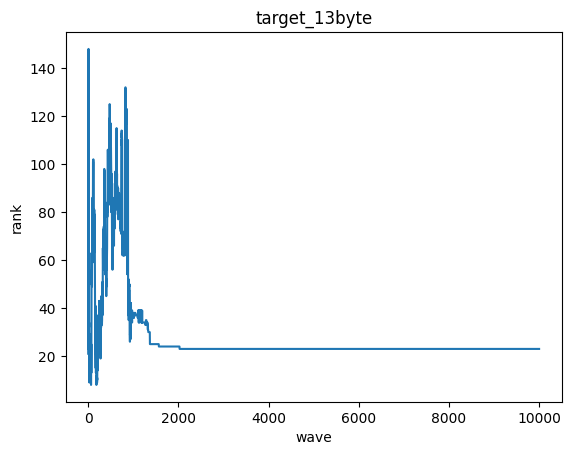

In [336]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [337]:
TARGET_BYTE = 14 #何バイト目を攻撃するか決める

In [338]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [339]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [340]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [341]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [342]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [343]:
train_trace = train_trace[0:45000, 49565:50265]
test_trace = test_trace[45000:50000, 49565:50265]
attack_trace = attack_trace[50000:60000, 49565:50265]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [344]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [345]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [346]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [347]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [348]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [349]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [350]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [351]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [352]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:215.0627, SR:0.0 last trace rank:223
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:214.5412, SR:0.0 last trace rank:197
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:213.0793, SR:0.0 last trace rank:192
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:212.4222, SR:0.0 last trace rank:190
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:210.70714, SR:2e-05 last trace rank:187
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:208.41613333333333, SR:3.3333333333333335e-05 last trace rank:185
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:205.53295714285716, SR:2.857142857142857e-05 last trace rank:162
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:202.38665, SR:2.5e-05 last trace rank:157
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:199.13606666666666, SR:2.22

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 113 - GE:48.43285132743363, SR:0.505324778761062 last trace rank:92
313/313 [==============================] - 2s 5ms/step
Epoch 114 - GE:48.79981315789474, SR:0.5008921052631579 last trace rank:92
313/313 [==============================] - 2s 5ms/step
Epoch 115 - GE:48.40925739130435, SR:0.5042895652173913 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 116 - GE:48.03927758620689, SR:0.5059327586206896 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 117 - GE:48.30971965811966, SR:0.501608547008547 last trace rank:92
313/313 [==============================] - 2s 5ms/step
Epoch 118 - GE:48.68771525423729, SR:0.49735762711864406 last trace rank:92
313/313 [==============================] - 2s 5ms/step
Epoch 119 - GE:49.01659075630252, SR:0.4931781512605042 last trace rank:92
313/313 [==============================] - 2s 5ms/step
Epoch 120 - GE:48.64964333333333, SR:0.4955025 last trace rank:1
313/313 [===================

Text(0.5, 1.0, 'target_14byte')

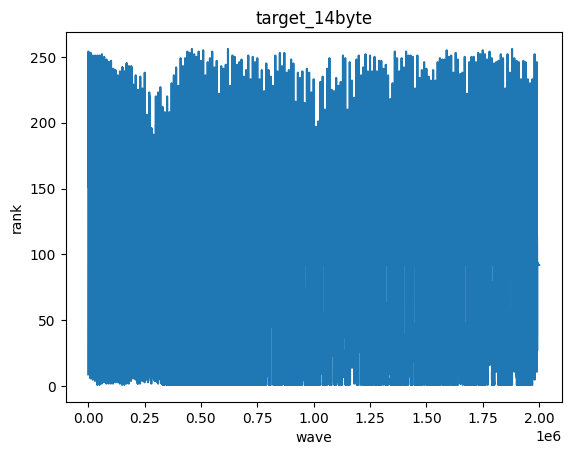

In [353]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

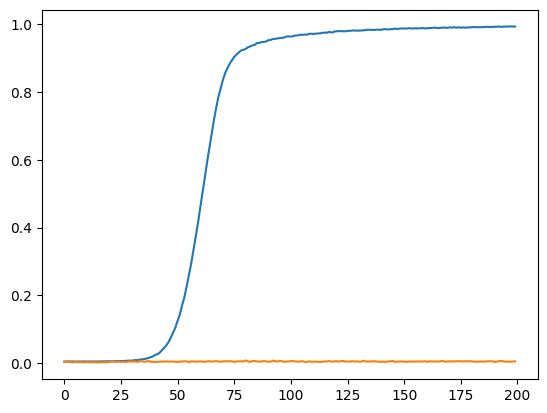

In [354]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [355]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [356]:
attack_plain=attack_metadata['plaintext']

In [357]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [358]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [359]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_14byte')

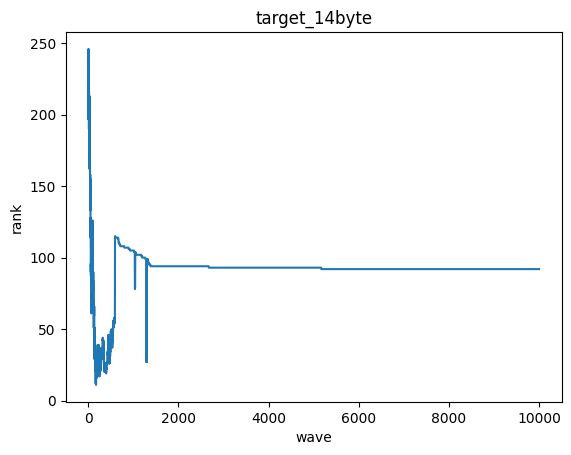

In [360]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

In [361]:
TARGET_BYTE = 15 #何バイト目を攻撃するか決める

In [362]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [363]:
data_train = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_test = h5py.File('ATMega8515_raw_traces.h5', 'r')
data_attack = h5py.File('ATMega8515_raw_traces.h5', 'r')

In [364]:
train_metadata=data_train['metadata']
train_plain = train_metadata['plaintext']
train_cipher = train_metadata['ciphertext']
train_key = train_metadata['key']
train_mask = train_metadata['masks']
train_trace = data_train['traces']

test_metadata=data_test['metadata']
test_plain = test_metadata['plaintext']
test_cipher = test_metadata['ciphertext']
test_key = test_metadata['key']
test_mask = test_metadata['masks']
test_trace = data_train['traces']

attack_metadata=data_attack['metadata']
attack_plain = attack_metadata['plaintext']
attack_cipher = attack_metadata['ciphertext']
attack_key = attack_metadata['key']
attack_mask = attack_metadata['masks']
attack_trace = data_train['traces']

In [365]:
print(train_metadata.shape, train_trace.shape, train_plain.shape, train_cipher.shape, train_key.shape, train_mask.shape)

(60000,) (60000, 100000) (60000, 16) (60000, 16) (60000, 16) (60000, 16)


In [366]:
keys=np.array([0x4D,0xFB,0xE0,0xF2,0x72,0x21,0xFE,0x10,0xA7,0x8D,0x4A,0xDC,0x8E,0x49,0x04,0x69])

In [367]:
train_trace = train_trace[0:45000, 18330:19030]
test_trace = test_trace[45000:50000, 18330:19030]
attack_trace = attack_trace[50000:60000, 18330:19030]
train_plain = train_plain[0:45000, :]
test_plain = test_plain[45000:50000, :]
train_trace2 = train_trace
test_trace2 = test_trace
attack_trace2 = attack_trace
train_trace.shape

(45000, 700)

In [368]:
train_key = train_key[0:45000,:]
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])

In [369]:
test_key = test_key[0:5000,:]
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])

In [370]:
train_sbox_out = train_sbox_out[:,TARGET_BYTE]
test_sbox_out = test_sbox_out[:,TARGET_BYTE]

In [371]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(45000,700,1)

test_trace2 = test_trace2.reshape(5000,700,1)

attack_trace2 = attack_trace2.reshape(10000,700,1)

In [372]:
def cnn_best(classes=256,input_dim=700):
	# From VGG16 design
	input_shape = (input_dim,1)
	img_input = Input(shape=input_shape)
	# Block 1
	x = Conv1D(64, 11, activation='relu', padding='same', name='block1_conv1')(img_input)
	x = AveragePooling1D(2, strides=2, name='block1_pool')(x)
	# Block 2
	x = Conv1D(128, 11, activation='relu', padding='same', name='block2_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block2_pool')(x)
	# Block 3
	x = Conv1D(256, 11, activation='relu', padding='same', name='block3_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block3_pool')(x)
	# Block 4
	x = Conv1D(512, 11, activation='relu', padding='same', name='block4_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block4_pool')(x)
	# Block 5
	x = Conv1D(512, 11, activation='relu', padding='same', name='block5_conv1')(x)
	x = AveragePooling1D(2, strides=2, name='block5_pool')(x)
	# Classification block
	x = Flatten(name='flatten')(x)
	x = Dense(4096, activation='relu', name='fc1')(x)
	x = Dense(4096, activation='relu', name='fc2')(x)
	# x = Dense(classes, activation='softmax', name='predictions')(x)
	x = Dense(classes, name='predictions')(x)

	inputs = img_input
	# Create model.
	model = Model(inputs, x, name='cnn_best')
	optimizer = RMSprop(learning_rate=0.00001)
	loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
	# model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])
	return model

In [373]:
cnn_best()
model=cnn_best(classes=256,input_dim=700)

In [374]:
rank = []
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_trace2 , label, TARGET_BYTE, rank_save_dir, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.data_test = test_trace2
        self.label = label.T
        self.target_byte = TARGET_BYTE
        self.save_dir = rank_save_dir
    def on_epoch_end(self, epoch, logs=None):
        predicts = model.predict(attack_trace2)
        predicts = tf.nn.softmax(predicts)
        attack_plain=attack_metadata['plaintext']
        attack_sbox_in = []
        for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
            attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
        attack_sbox_in = np.array(attack_sbox_in)
        attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
        attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]
        attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用
        result = np.ones(256) /256
        attack_sbox_out = np.array(attack_sbox_out)
        pred = predicts.numpy()

        for i in range(len(predicts)):
            result *= pred[i, attack_sbox_out[:, i]]
            result = result /np.sum(result)
            rank.append(list(np.argsort(result)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
        
        np.save(self.save_dir + f'/rank_result_{epoch+1}', np.array(rank))
        print(f'Epoch {epoch+1} - GE:{np.mean(rank)}, SR:{np.sum(np.array(rank)==1)/len(rank)} last trace rank:{rank[-1]}')


In [375]:
rank_save_dir = f"./save_file/fixed2_lr0.001_target_byte_{TARGET_BYTE}/rank_save/"
os.makedirs(rank_save_dir, exist_ok=True)

In [376]:
result = model.fit(train_trace2,train_sbox_out,  # 波形データとラベルデータ
                        batch_size=200,
                        epochs=200,     # エポック数の指定
                        validation_data=(test_trace2,test_sbox_out),
                        callbacks=[CustomCallback(test_trace2, test_sbox_out, TARGET_BYTE, rank_save_dir)],
                       verbose = 0
                        )

313/313 [==============================] - 2s 5ms/step
Epoch 1 - GE:45.4781, SR:0.0013 last trace rank:38
313/313 [==============================] - 2s 5ms/step
Epoch 2 - GE:38.6308, SR:0.0007 last trace rank:30
313/313 [==============================] - 2s 5ms/step
Epoch 3 - GE:33.15873333333333, SR:0.00046666666666666666 last trace rank:18
313/313 [==============================] - 2s 5ms/step
Epoch 4 - GE:29.93905, SR:0.00115 last trace rank:17
313/313 [==============================] - 2s 5ms/step
Epoch 5 - GE:27.92008, SR:0.00094 last trace rank:17
313/313 [==============================] - 2s 5ms/step
Epoch 6 - GE:26.350516666666667, SR:0.00115 last trace rank:16
313/313 [==============================] - 2s 5ms/step
Epoch 7 - GE:25.424842857142856, SR:0.001142857142857143 last trace rank:16
313/313 [==============================] - 2s 5ms/step
Epoch 8 - GE:25.0976125, SR:0.001 last trace rank:20
313/313 [==============================] - 2s 5ms/step
Epoch 9 - GE:24.346911111111

/tmp/ipykernel_10/2438822714.py:26: RuntimeWarning: invalid value encountered in true_divide
  result = result /np.sum(result)


Epoch 161 - GE:6.23572049689441, SR:0.8034645962732919 last trace rank:56
313/313 [==============================] - 2s 5ms/step
Epoch 162 - GE:6.204290740740741, SR:0.8046 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 163 - GE:6.173168098159509, SR:0.8057171779141105 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 164 - GE:6.142105487804878, SR:0.8068329268292683 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 165 - GE:6.111809090909091, SR:0.8078709090909091 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 166 - GE:6.081651807228916, SR:0.8089644578313253 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 167 - GE:6.051471856287425, SR:0.8100664670658683 last trace rank:1
313/313 [==============================] - 2s 5ms/step
Epoch 168 - GE:6.021982738095238, SR:0.8111291666666667 last trace rank:1
313/313 [==========================

Text(0.5, 1.0, 'target_15byte')

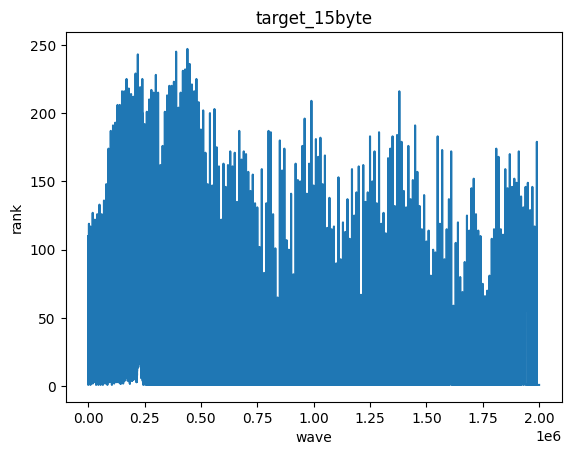

In [377]:
plt.figure()
plt.plot(rank)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))

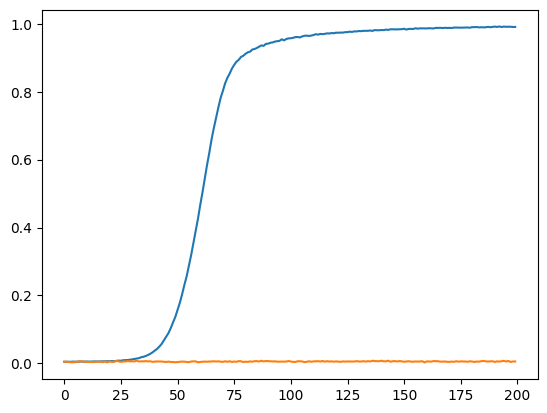

In [378]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

In [379]:
predicts = model.predict(attack_trace2)
predicts = tf.nn.softmax(predicts)
predicts.shape

313/313 [==============================] - 2s 5ms/step


TensorShape([10000, 256])

In [380]:
attack_plain=attack_metadata['plaintext']

In [381]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out = attack_sbox_out[:,:,TARGET_BYTE]

In [382]:
attack_sbox_out = attack_sbox_out[:,50000:] #全体の内, 最後の10000を攻撃に使用

In [383]:
result2 = np.ones(256) /256
rank = []
attack_sbox_out = np.array(attack_sbox_out)
pred = predicts.numpy()

for i in range(len(predicts)):
    result2 *= pred[i, attack_sbox_out[:, i]]
    result2 = result2 /np.sum(result2)
    rank.append(list(np.argsort(result2)[::-1]).index(attack_key[0][TARGET_BYTE])+1)
    

Text(0.5, 1.0, 'target_15byte')

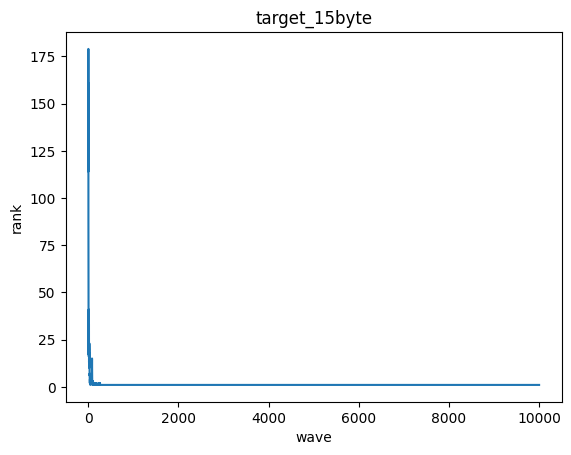

In [384]:
rank_lim = rank[0:10000]
plt.figure()
plt.plot(rank_lim)
plt.xlabel('wave')
plt.ylabel('rank')
plt.title('target_{}byte'.format(TARGET_BYTE))